In [1]:
import numpy as np
import torch
import torch.optim as optim

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([10,  3,  8,  7,  4,  6,  1,  5,  9]), tensor([0, 2]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [8]:
import torch.nn as nn

linear_model = nn.Linear(1, 1)# # of input features, # of output features,
                                # and whether linear model includes a bias (default True)
linear_model(t_un_val) # Don't call forward directly, many hooks don't get implemented

tensor([[-2.3404],
        [-4.3047]], grad_fn=<AddmmBackward>)

In [9]:
# We have an instance of nn.Linear with one input and one output
linear_model.weight

Parameter containing:
tensor([[-0.8730]], requires_grad=True)

In [10]:
linear_model.bias

Parameter containing:
tensor([0.7763], requires_grad=True)

In [11]:
# We can call the model with some input
x = torch.ones(1)
linear_model(x), x

(tensor([-0.0967], grad_fn=<AddBackward0>), tensor([1.]))

In [12]:
# to accomodate multiple samples, modules expect the zeroth dimension of the input to be number of samplse in the batch
# Refer chapter 4

In [13]:
# Batching Inputs
# If running it on 10 samples, create tensor of size B * Nin
# B is size of a batch, Nin is number of input features
x = torch.ones(10, 1)
linear_model(x), x

(tensor([[-0.0967],
         [-0.0967],
         [-0.0967],
         [-0.0967],
         [-0.0967],
         [-0.0967],
         [-0.0967],
         [-0.0967],
         [-0.0967],
         [-0.0967]], grad_fn=<AddmmBackward>),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]]))

In [40]:
linear_model = nn.Linear(1, 1) # Just a redifination
optimizer = optim.SGD( 
                    linear_model.parameters(),
                    lr = 1e-2)

In [41]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.8873]], requires_grad=True),
 Parameter containing:
 tensor([0.3083], requires_grad=True)]

In [42]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val) # Model is now passed in without individual parameters
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch%500 == 0:
            print(f"Epoch {epoch}, Training Loss {loss_train.item():.4f}, Validation Loss {loss_val.item():.4f}")

In [43]:
training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model = linear_model,
    loss_fn= nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val)

Epoch 1, Training Loss 93.9701, Validation Loss 49.8173
Epoch 500, Training Loss 7.8184, Validation Loss 9.9691
Epoch 1000, Training Loss 3.9934, Validation Loss 4.2970
Epoch 1500, Training Loss 3.3427, Validation Loss 2.7100
Epoch 2000, Training Loss 3.2320, Validation Loss 2.1834
Epoch 2500, Training Loss 3.2132, Validation Loss 1.9880
Epoch 3000, Training Loss 3.2100, Validation Loss 1.9111


In [44]:
print(linear_model.weight)
print(linear_model.bias)

Parameter containing:
tensor([[5.2382]], requires_grad=True)
Parameter containing:
tensor([-16.5797], requires_grad=True)


In [45]:
# Creating a sequential model
seq_model = nn.Sequential(
                nn.Linear(1, 13),
                nn.Tanh(),
                nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [46]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [47]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [81]:
# Name is just the ordinal number above, to give custom names, use orderedDict
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_layer', nn.Linear(1, 4)),
    ('hidden_activation', nn.Tanh()),
    (('output_linear'), nn.Linear(4, 1))
]))

In [82]:
seq_model

Sequential(
  (hidden_layer): Linear(in_features=1, out_features=4, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=4, out_features=1, bias=True)
)

In [83]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_layer.weight torch.Size([4, 1])
hidden_layer.bias torch.Size([4])
output_linear.weight torch.Size([1, 4])
output_linear.bias torch.Size([1])


In [84]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.0964], requires_grad=True)

In [85]:
# Checking the weights
optimizer = optim.SGD(seq_model.parameters(), lr = 1e-3)

training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model = seq_model,
    loss_fn= nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val)

print("Output", seq_model(t_un_val))
print("Answer", t_c_val)
print("Hidden", seq_model.hidden_layer.weight.grad)

Epoch 1, Training Loss 206.8994, Validation Loss 114.6225
Epoch 500, Training Loss 21.5447, Validation Loss 6.4317
Epoch 1000, Training Loss 9.5119, Validation Loss 0.5920
Epoch 1500, Training Loss 13.8221, Validation Loss 4.4562
Epoch 2000, Training Loss 8.1480, Validation Loss 3.0090
Epoch 2500, Training Loss 4.3504, Validation Loss 2.8596
Epoch 3000, Training Loss 2.7457, Validation Loss 3.4208
Epoch 3500, Training Loss 2.0586, Validation Loss 4.1098
Epoch 4000, Training Loss 1.7316, Validation Loss 4.7963
Epoch 4500, Training Loss 1.5595, Validation Loss 5.3509
Epoch 5000, Training Loss 1.4614, Validation Loss 5.7620
Output tensor([[ 3.3458],
        [12.5994]], grad_fn=<AddmmBackward>)
Answer tensor([[ 0.5000],
        [15.0000]])
Hidden tensor([[-9.4510],
        [10.6783],
        [-1.0413],
        [-0.1877]])


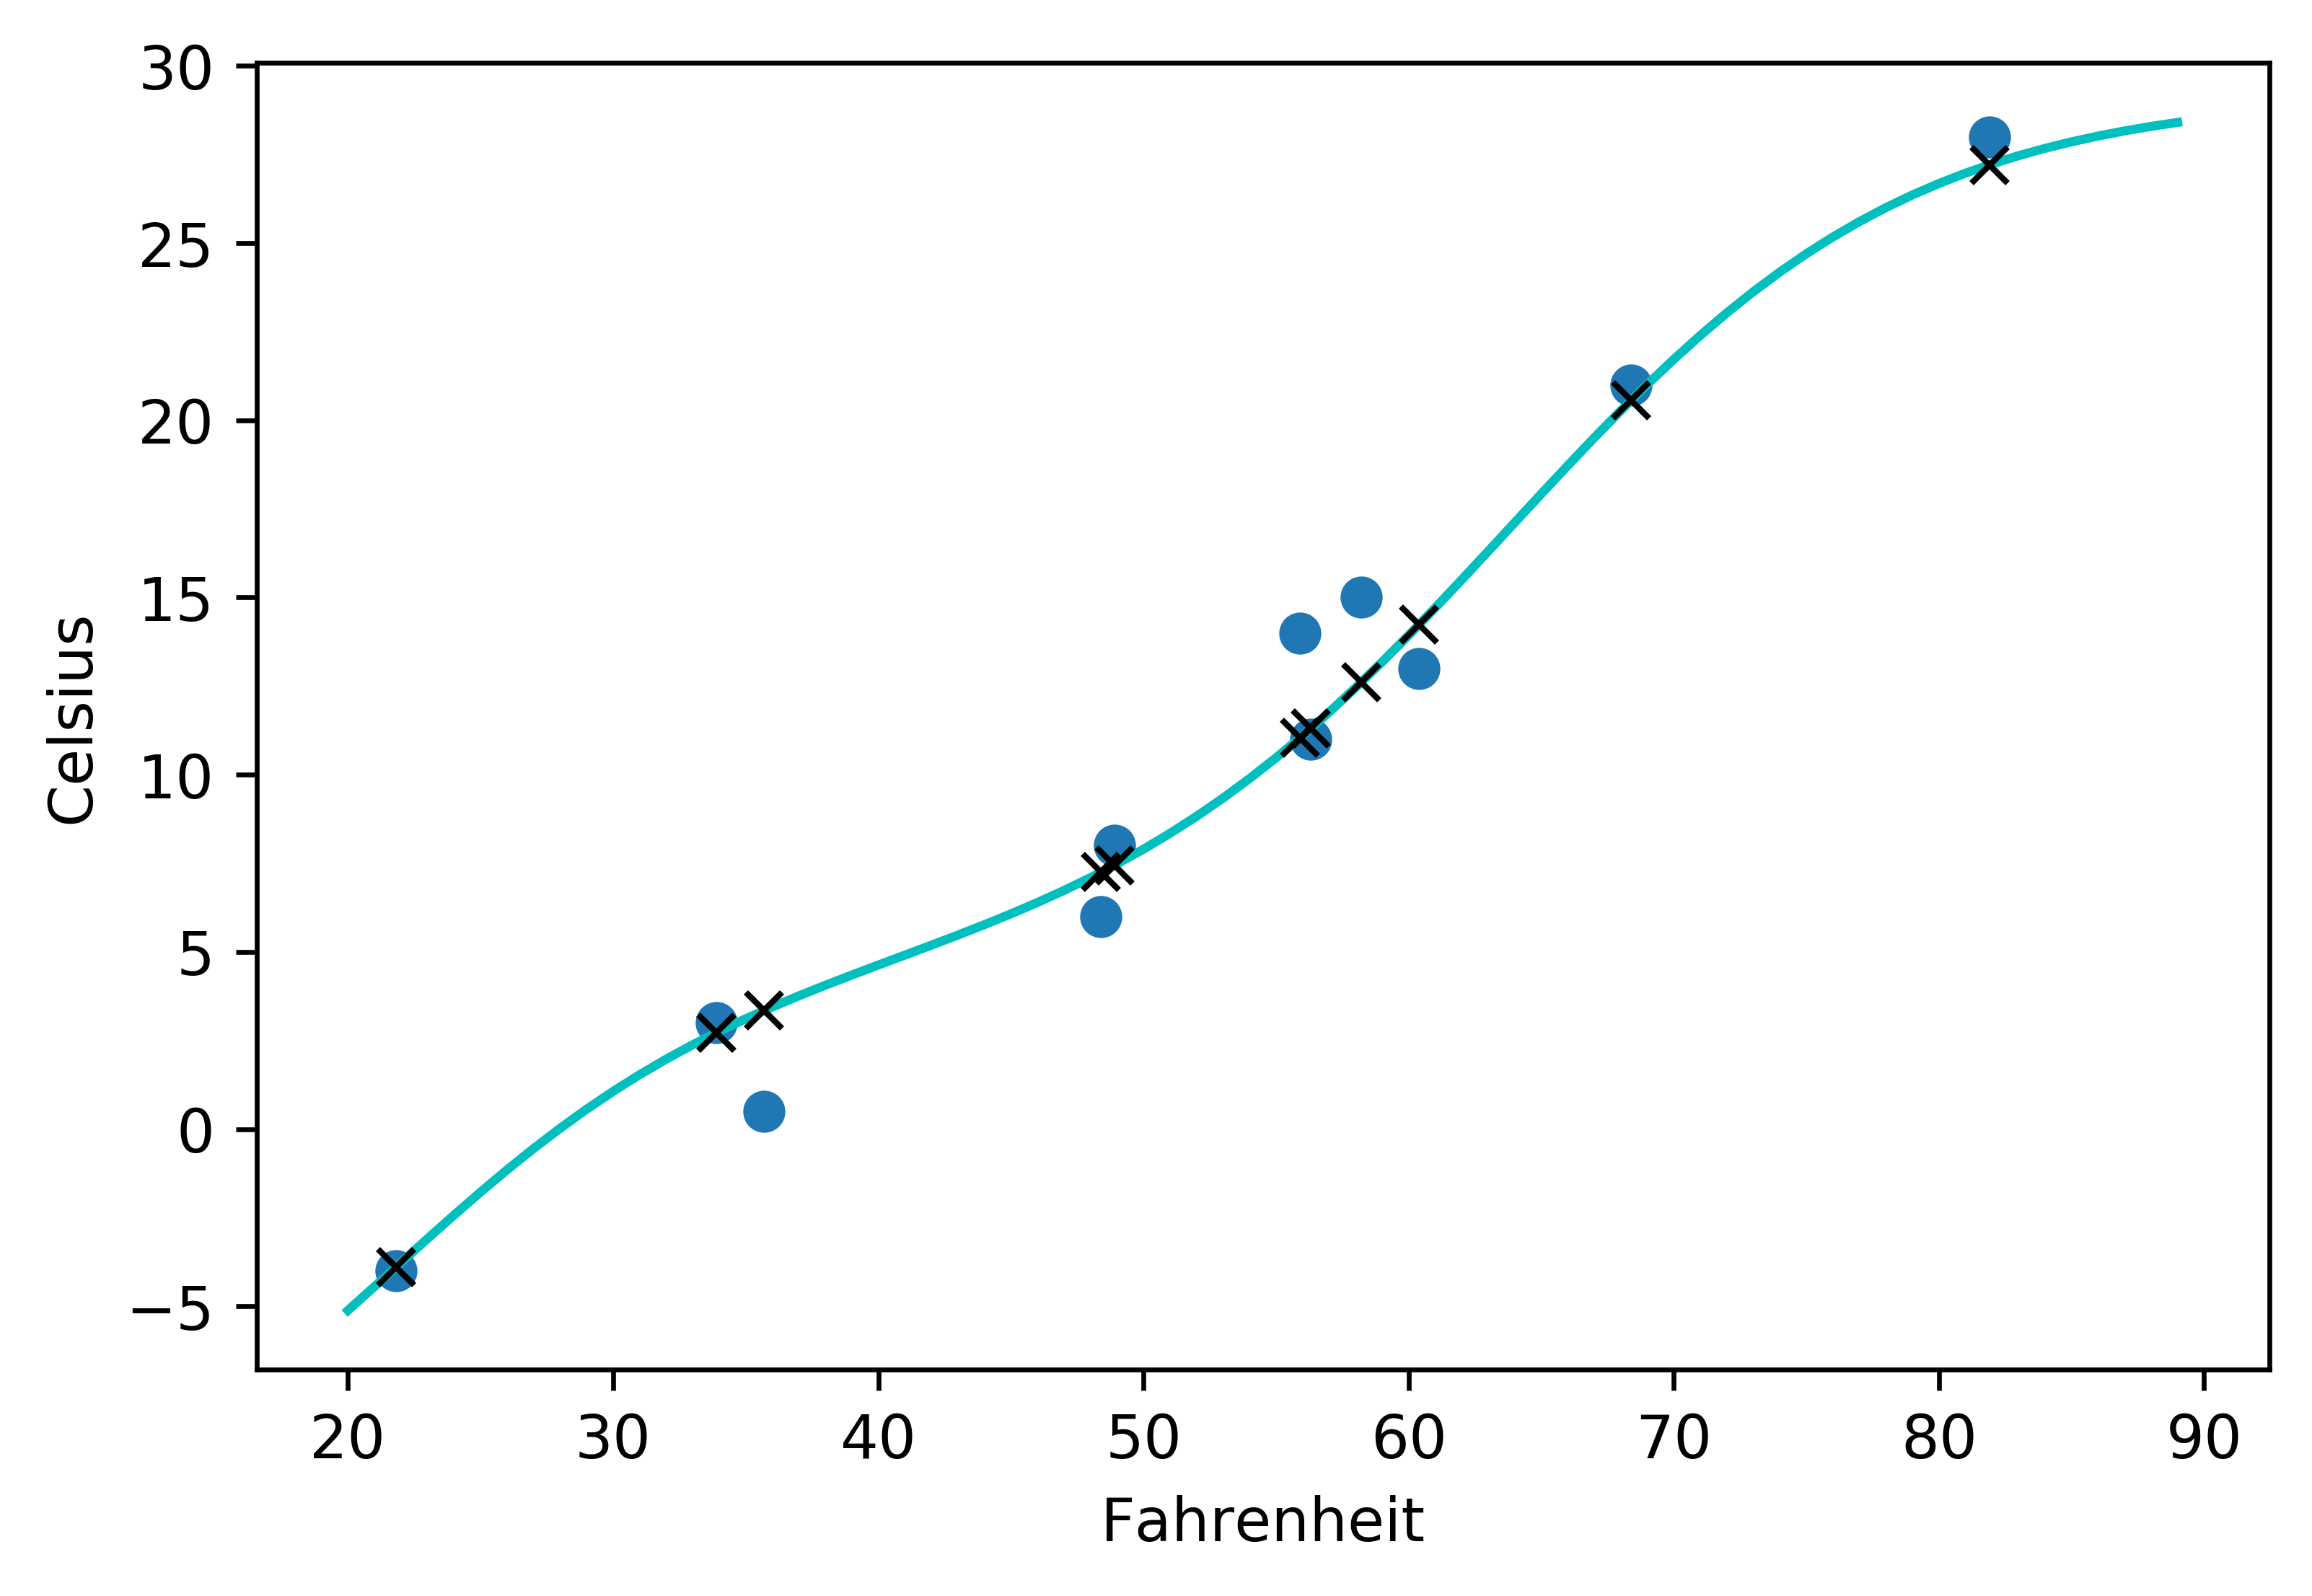

In [86]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
